# 🌺 ResNet-50 Image Classification

<details>
<summary><strong>📋 About This Project & Objectives</strong></summary>

This exercise implements the ResNet-50 image classification, a classic case in the deep learning field. This project demonstrates advanced computer vision techniques using a deep residual network architecture.

**Learning Objectives:**

- 🌺 Master flower image dataset preprocessing and augmentation techniques
- 🏗️ Build and configure ResNet-50 architecture with residual connections
- ⚙️ Implement deep network training strategies with skip connections

**Project Workflow:**
- ⚫ Process the required dataset (flower image dataset)
- ⚫ Define a network (ResNet-50 model structure)
- ⚫ Define a loss function and an optimizer
- ⚫ Load the dataset and perform training
- ⚫ After training completion, use the test set for validation

</details>

## 📚 Imports and Environment Setup
Setting up the required libraries and environment for ResNet-50 image classification.

In [1]:
# Import the Python library and module and configure running information.

from warnings import filterwarnings
filterwarnings('ignore')

from easydict import EasyDict as edict  # Dictionary access, used to store hyperparameters
import os  # os module, used to process files and directories
import numpy as np  # Scientific computing library
import matplotlib.pyplot as plt  # Graphing library

import mindspore  # MindSpore library
import mindspore.dataset as ds  # Dataset processing module
from mindspore.dataset.vision import c_transforms as vision  # Image enhancement module
from mindspore import context  # Environment setting module

import mindspore.nn as nn  # Neural network module
from mindspore.train import Model  # Model build
from mindspore.nn.optim.momentum import Momentum  # Momentum optimizer
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor  # Model saving settings

from mindspore import Tensor  # Tensor
from mindspore.train.serialization import export  # Model export
from mindspore.train.loss_scale_manager import FixedLossScaleManager  # Loss value smoothing
from mindspore.train.serialization import load_checkpoint, load_param_into_net  # Model loading
import mindspore.ops as ops  # Common operators

# MindSpore execution mode and device setting
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

In [2]:
# Define parameter variables.
cfg = edict({
    # Dataset configuration
    'train_data_path': '../flower_photos_train',  # Path of the training dataset
    'val_data_path': '../flower_photos_test',     # Path of the test dataset
    'data_size': 3616,                         # Total number of training samples
    
    # Image preprocessing parameters
    'HEIGHT': 224,                             # Image height
    'WIDTH': 224,                              # Image width
    '_R_MEAN': 123.675,                        # RGB mean values for normalization
    '_G_MEAN': 116.28,
    '_B_MEAN': 103.53,
    '_R_STD': 58.395,                          # RGB standard deviation
    '_G_STD': 57.12,
    '_B_STD': 57.375,
    '_RESIZE_SIDE_MIN': 256,                   # Minimum resize value for image enhancement
    '_RESIZE_SIDE_MAX': 512,                   # Maximum resize value for image enhancement
    
    # Training configuration
    'batch_size': 32,                          # Batch size
    'num_classes': 5,                          # Number of classes: 5 flowers
    'epoch_size': 15,                          # Number of training epochs
    'loss_scale_num': 1024,                    # Loss scale for mixed precision training
    
    # Model saving configuration
    'prefix': 'resnet-ai',                     # Name of the model
    'directory': './model_resnet',             # Path for storing the model
    'save_checkpoint_steps': 10,               # The checkpoint is saved every 10 steps
})

print("Configuration parameters loaded successfully!")
print(f"Dataset: {cfg.num_classes} flower classes")
print(f"Image size: {cfg.HEIGHT}x{cfg.WIDTH}")
print(f"Batch size: {cfg.batch_size}")
print(f"Training epochs: {cfg.epoch_size}")

Configuration parameters loaded successfully!
Dataset: 5 flower classes
Image size: 224x224
Batch size: 32
Training epochs: 15


## 🌺 Dataset Loading and Exploration
Processing the flower image dataset for classification with ResNet-50.

In [3]:
# Read flower dataset and create data loaders
# Data processing
def read_data(path, config, usage="train"):
    # Read the source dataset of an image from a directory.
    dataset = ds.ImageFolderDataset(path, 
                                   class_indexing={'daisy': 0, 'dandelion': 1, 'roses': 2, 
                                                  'sunflowers': 3, 'tulips': 4})
    
    # Define map operations
    # Operator for image decoding
    decode_op = vision.Decode() 
    
    # Operator for image normalization
    normalize_op = vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], 
                                   std=[cfg._R_STD, cfg._G_STD, cfg._B_STD])
    
    # Operator for image resizing
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    
    # Operator for image cropping
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    
    # Operator for image random horizontal flipping
    horizontal_flip_op = vision.RandomHorizontalFlip()
    
    # Operator for image channel quantity conversion
    channelswap_op = vision.HWC2CHW()
    
    # Operator for random image cropping, decoding, encoding, and resizing
    random_crop_decode_resize_op = vision.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), 
                                                                (0.5, 1.0), (1.0, 1.0), 
                                                                max_attempts=100)
    
    # Preprocess the training set
    if usage == 'train':
        dataset = dataset.map(input_columns="image", operations=random_crop_decode_resize_op)
        dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
    
    # Preprocess the test set
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)
    
    # Preprocess all datasets
    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=channelswap_op)
    
    # Batch the training set
    if usage == 'train':
        dataset = dataset.shuffle(buffer_size=10000)  # 10000 as in imageNet train script
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    
    # Batch the test set
    else:
        dataset = dataset.batch(1, drop_remainder=True)
    
    # Data augmentation
    dataset = dataset.repeat(1)
    
    dataset.map_model = 4
    return dataset

# Display the numbers of training sets and test sets
de_train = read_data(cfg.train_data_path, cfg, usage="train")
de_test = read_data(cfg.val_data_path, cfg, usage="test")
print('Number of training datasets: ', de_train.get_dataset_size() * cfg.batch_size)
print('Number of test datasets: ', de_test.get_dataset_size())

# Display the sample graph of the training set
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('Number of channels/Image length/width: ', data_next['image'][0, ...].shape)
print('Label style of an image: ', data_next['label'][0])  # Total 5 label classes represented by numbers 0-4

[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:15.708.496 [mindspore/dataset/core/validator_helpers.py:744] 'Decode' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Decode' from mindspore.dataset.vision instead.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:15.709.804 [mindspore/dataset/core/validator_helpers.py:744] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:15.711.050 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:15.712.159 [mindspore/datas

[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:15.708.496 [mindspore/dataset/core/validator_helpers.py:744] 'Decode' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Decode' from mindspore.dataset.vision instead.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:15.709.804 [mindspore/dataset/core/validator_helpers.py:744] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:15.711.050 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:15.712.159 [mindspore/datas

Number of training datasets:  3616
Number of test datasets:  52
Number of channels/Image length/width:  (3, 224, 224)
Label style of an image:  1
Number of channels/Image length/width:  (3, 224, 224)
Label style of an image:  1


Number of channels/Image length/width:  (3, 224, 224)
Label style of an image:  3


Number of channels/Image length/width:  (3, 224, 224)
Label style of an image:  3


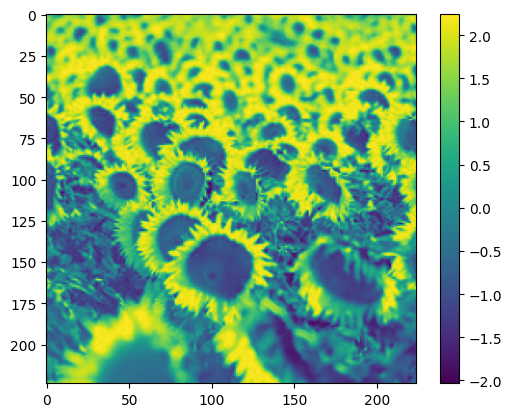

In [4]:
# Display the sample graph of the training set
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('Number of channels/Image length/width: ', data_next['image'][0, ...].shape)
print('Label style of an image: ', data_next['label'][0])  # Total 5 label classes represented by numbers 0-4

# Plot the sample image
plt.figure()
plt.imshow(data_next['image'][0, 0, ...])
plt.colorbar()
plt.grid(False)
plt.show()

## 🏗️ ResNet-50 Architecture
Building the ResNet-50 network with residual connections for deep flower image classification.

In [5]:
# ResNet-50 Implementation - Helper functions and basic components
"""ResNet helper functions for weight initialization and layer construction."""

# Define the weight initialization function
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)

# Define the 3x3 convolution layer functions
def _conv3x3(in_channel, out_channel, stride=1):
    return nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, 
                     padding=1, pad_mode='pad', has_bias=False)

# Define the 1x1 convolution layer functions
def _conv1x1(in_channel, out_channel, stride=1):
    return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, 
                     padding=0, pad_mode='pad', has_bias=False)

# Define the 7x7 convolution layer functions
def _conv7x7(in_channel, out_channel, stride=1):
    return nn.Conv2d(in_channel, out_channel, kernel_size=7, stride=stride, 
                     padding=3, pad_mode='pad', has_bias=False)

# Define the Batch Norm layer functions
def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                         gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

# Define the Batch Norm functions at the last layer
def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                         gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)

# Define the functions of the fully-connected layers
def _fc(in_channel, out_channel):
    return nn.Dense(in_channel, out_channel)

In [6]:
# ResNet-50 Implementation - ResidualBlock class
"""Implementation of the residual block with bottleneck design."""

class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.
    """
    expansion = 4
    
    def __init__(self,
                 in_channel,
                 channel,
                 stride=1,
                 down_sample=False):
        super(ResidualBlock, self).__init__()
        
        # First 1x1 convolution layer
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)
        
        # Second 3x3 convolution layer
        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)
        
        # Third 1x1 convolution layer
        self.conv3 = _conv1x1(channel, channel * self.expansion, stride=1)
        self.bn3 = _bn_last(channel * self.expansion)
        
        # ReLU activation function
        self.relu = nn.ReLU()
        
        # Downsampling layer for skip connection
        self.down_sample = down_sample
        if self.down_sample:
            self.down_sample_layer = _conv1x1(in_channel, channel * self.expansion, stride=stride)
            self.down_sample_bn = _bn(channel * self.expansion)
    
    def construct(self, x):
        """Forward pass through residual block."""
        # Store identity for skip connection
        identity = x
        
        # First bottleneck layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Second bottleneck layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # Third bottleneck layer
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Apply downsampling if needed
        if self.down_sample:
            identity = self.down_sample_layer(identity)
            identity = self.down_sample_bn(identity)
        
        # Add skip connection and apply activation
        out += identity
        out = self.relu(out)
        
        return out

In [7]:
# ResNet-50 Backbone - deep residual network with 50 layers
class ResNet(nn.Cell):
    """
    ResNet architecture.
    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        strides (list): Stride size in each layer.
        num_classes (int): The number of classes that the training images belong to.
    Returns:
        Tensor, output tensor.
    Examples:
        >>> ResNet(ResidualBlock, [3, 4, 6, 3], [64, 256, 512, 1024], 
        >>>         [256, 512, 1024, 2048], [1, 2, 2, 2], 10)
    """
    
    def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes):
        super(ResNet, self).__init__()
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")
        
        # Initial convolution layer (7x7 conv, stride=2)
        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()
        
        # Max pooling layer (3x3, stride=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")
        
        # Residual blocks for different stages
        # conv2_x residual block
        self.layer1 = self._make_layer(block, layer_nums[0], in_channels[0], 
                                      out_channels[0], strides[0])
        
        # conv3_x residual block
        self.layer2 = self._make_layer(block, layer_nums[1], in_channels[1], 
                                      out_channels[1], strides[1])
        
        # conv4_x residual block
        self.layer3 = self._make_layer(block, layer_nums[2], in_channels[2], 
                                      out_channels[2], strides[2])
        
        # conv5_x residual block
        self.layer4 = self._make_layer(block, layer_nums[3], in_channels[3], 
                                      out_channels[3], strides[3])
        
        # Global average pooling and classification head
        self.mean = ops.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3] * block.expansion, num_classes)
    
    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.
        Args:
            block (Cell): Resnet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for the first convolutional layer.
        Returns:
            SequentialCell, the output layer.
        """
        layers = []
        
        # First block with potential downsampling
        # Downsampling is needed when stride > 1 or input channels != output channels * expansion
        down_sample = stride != 1 or in_channel != out_channel * block.expansion
        resnet_block = block(in_channel, out_channel, stride=stride, down_sample=down_sample)
        layers.append(resnet_block)
        
        # Remaining blocks
        for _ in range(1, layer_num):
            resnet_block = block(out_channel * block.expansion, out_channel, stride=1, down_sample=False)
            layers.append(resnet_block)
        
        return nn.SequentialCell(layers)
    
    def construct(self, x): 
        # Initial convolution and pooling
        x = self.conv1(x)  # 7x7 conv, stride=2
        x = self.bn1(x)    # Batch normalization
        x = self.relu(x)   # ReLU activation
        c1 = self.maxpool(x)  # Max pooling 3x3, stride=2
        
        # Pass through residual blocks
        c2 = self.layer1(c1)  # conv2_x residual block
        c3 = self.layer2(c2)  # conv3_x residual block
        c4 = self.layer3(c3)  # conv4_x residual block
        c5 = self.layer4(c4)  # conv5_x residual block
        
        # Global average pooling and classification
        out = self.mean(c5, (2, 3))  # Global average pooling
        out = self.flatten(out)      # Flatten
        out = self.end_point(out)    # Classification head
        return out

In [8]:
# ResNet-50 Factory Function - creates the complete ResNet-50 model
def resnet50(class_num=5):
    """
    Get ResNet50 neural network.
    Args:
        class_num (int): Class number.
    Returns:
        Cell, cell instance of ResNet50 neural network.
    Examples:
        >>> net = resnet50(10)
    """
    return ResNet(
        ResidualBlock,           # Residual block type
        [3, 4, 6, 3],           # Number of residual blocks per stage
        [64, 256, 512, 1024],   # Input channels for each stage (actual input channels)
        [64, 128, 256, 512],    # Output channels for each stage (base channels)
        [1, 2, 2, 2],           # Strides for each stage
        class_num               # Number of output classes
    )

In [9]:
# Create ResNet-50 model for flower classification
net = resnet50(class_num=cfg.num_classes)
print("ResNet-50 model created successfully!")
print(f"Model configured for {cfg.num_classes} flower classes")

ResNet-50 model created successfully!
Model configured for 5 flower classes


## ⚙️ Loss Function and Optimizer Configuration
Setting up the training components for ResNet-50 optimization.

In [10]:
# Define loss function and metrics
import mindspore.nn as nn

# Simple cross-entropy loss for classification
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# Basic accuracy metric
from mindspore.nn.metrics import Accuracy
accuracy_metric = Accuracy()

print("Loss function and metrics configured successfully!")
print(f"Loss: {loss_fn}")
print(f"Metric: {accuracy_metric}")
print("Note: Optimizer will be configured later when model parameters are available")

Loss function and metrics configured successfully!
Loss: SoftmaxCrossEntropyWithLogits<>
Metric: <mindspore.train.metrics.accuracy.Accuracy object at 0x7c691abb4490>
Note: Optimizer will be configured later when model parameters are available


## 📈 Model Training
Training the ResNet-50 network on the flower image dataset.

In [11]:
# Model Creation and Pre-trained Weights Loading
# Construct a ResNet-50 network. The number of output classes is 5, corresponding to five flower 
# classes.
net = resnet50(class_num=cfg.num_classes)

# Read the parameters of the pre-trained model.
param_dict = load_checkpoint("resnet50_ascend_v170_imagenet2012_official_cv_top1acc76.97_top5acc93.44.ckpt")

# Display the read model parameters.
print(param_dict)

# Modify the shape corresponding to end_point.weight and end_point.bias by using 
# mindspore.Parameter().
param_dict["end_point.weight"] = mindspore.Parameter(Tensor(param_dict["end_point.weight"][:5, :], mindspore.float32), name="variable")
param_dict["end_point.bias"] = mindspore.Parameter(Tensor(param_dict["end_point.bias"][:5], mindspore.float32), name="variable")

# Load the modified parameters into the network
load_param_into_net(net, param_dict)
print("Pre-trained weights loaded and adapted for flower classification!")

[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.454.30 [mindspore/train/serialization.py:1381] For 'load_param_into_net', 20 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.462.69 [mindspore/train/serialization.py:1383] layer1.0.down_sample_layer.weight is not loaded.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.467.86 [mindspore/train/serialization.py:1383] layer1.0.down_sample_bn.moving_mean is not loaded.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.472.57 [mindspore/train/serialization.py:1383] layer1.0.down_sample_bn.moving_variance is not loaded.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.477.05 [mindspore/train/serialization.py:1383] layer1.0.down_sample_bn.gamma is not loaded.
[WARNING] ME(2048:1

[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.454.30 [mindspore/train/serialization.py:1381] For 'load_param_into_net', 20 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.462.69 [mindspore/train/serialization.py:1383] layer1.0.down_sample_layer.weight is not loaded.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.467.86 [mindspore/train/serialization.py:1383] layer1.0.down_sample_bn.moving_mean is not loaded.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.472.57 [mindspore/train/serialization.py:1383] layer1.0.down_sample_bn.moving_variance is not loaded.
[WARNING] ME(2048:136792003170432,MainProcess):2025-09-11-16:13:20.477.05 [mindspore/train/serialization.py:1383] layer1.0.down_sample_bn.gamma is not loaded.
[WARNING] ME(2048:1

{'conv1.weight': Parameter (name=conv1.weight, shape=(64, 3, 7, 7), dtype=Float32, requires_grad=True), 'bn1.gamma': Parameter (name=bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'bn1.beta': Parameter (name=bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv1.weight': Parameter (name=layer1.0.conv1.weight, shape=(64, 64, 1, 1), dtype=Float32, requires_grad=True), 'layer1.0.bn1.gamma': Parameter (name=layer1.0.bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn1.beta': Parameter (name=layer1.0.bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv2.weight': Parameter (name=layer1.0.conv2.weight, shape=(64, 64, 3, 3), dtype=Float32, requires_grad=True), 'layer1.0.bn2.gamma': Parameter (name=layer1.0.bn2.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn2.beta': Parameter (name=layer1.0.bn2.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv3.weight': Parameter (name=layer1.0.co

In [12]:
# Learning Rate Schedule and Optimizer Configuration
# Set the Softmax cross-entropy loss function.
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# Set the learning rate.
learning_rate = 0.001

# Set the momentum optimizer.
optimizer = Momentum(params=net.trainable_params(), learning_rate=learning_rate, momentum=0.9, weight_decay=1e-4)

# Smooth the loss value to solve the problem of the gradient being too small during training.
loss_scale_manager = FixedLossScaleManager(loss_scale=cfg.loss_scale_num, drop_overflow_update=False)

In [13]:
# Model Compilation and Callbacks Setup

# Calculate training step size for epoch-end monitoring
train_step_size = de_train.get_dataset_size()
print(f"Training steps per epoch: {train_step_size}")

# Build the model. Input the network structure, loss function, optimizer, loss value smoothing, and model evaluation metrics.
model = Model(network=net, loss_fn=loss, optimizer=optimizer, loss_scale_manager=loss_scale_manager, metrics={'accuracy': nn.Accuracy()})

# Loss value monitoring - print at the end of each epoch
loss_cb = LossMonitor(per_print_times=train_step_size)

# Model saving parameters. Set the number of steps for saving a model and the maximum number of models that can be saved.
checkpoint_config = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps, keep_checkpoint_max=5)

# Save the model. Set the name, path, and parameters for saving the model.
ckpoint_cb = ModelCheckpoint(prefix=cfg.prefix, directory=cfg.directory, config=checkpoint_config)

Training steps per epoch: 113


In [14]:
# Training Execution and Evaluation
print("============== Starting Training ==============")

# Train the model. Set the training times, training set, callback function, and whether to use the data offloading mode (can be applied on Ascend and GPUs to accelerate training speed).
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb,ckpoint_cb], dataset_sink_mode=True)
# The training takes 30 to 35 minutes.

# Use the test set to validate the model and output the accuracy of the test set.
metric = model.eval(de_test)
print(metric)

============== Starting Training ==============
epoch: 1 step: 113, loss is 1.5844818353652954
epoch: 1 step: 113, loss is 1.5844818353652954
epoch: 2 step: 113, loss is 1.7509808540344238
epoch: 2 step: 113, loss is 1.7509808540344238
epoch: 3 step: 113, loss is 1.4546465873718262
epoch: 3 step: 113, loss is 1.4546465873718262
epoch: 4 step: 113, loss is 1.6823346614837646
epoch: 4 step: 113, loss is 1.6823346614837646
epoch: 5 step: 113, loss is 1.556390404701233
epoch: 5 step: 113, loss is 1.556390404701233
epoch: 6 step: 113, loss is 1.5886669158935547
epoch: 6 step: 113, loss is 1.5886669158935547
epoch: 7 step: 113, loss is 1.6320750713348389
epoch: 7 step: 113, loss is 1.6320750713348389
epoch: 8 step: 113, loss is 1.5809482336044312
epoch: 8 step: 113, loss is 1.5809482336044312
epoch: 9 step: 113, loss is 1.5016592741012573
epoch: 9 step: 113, loss is 1.5016592741012573
epoch: 10 step: 113, loss is 1.4400743246078491
epoch: 10 step: 113, loss is 1.4400743246078491
epoch: 11 st

## 🎯 Model  Testing
Validating the trained ResNet-50 model on the flower test dataset.

In [15]:
# Calculate overall prediction accuracy on test samples
print("============== Model Accuracy Assessment ==============")
correct_predictions = 0
total_samples = 0

# Test on multiple samples for statistical significance
for i in range(50):  # Test on 50 samples for better accuracy assessment
    test_ = de_test.create_dict_iterator().__next__()
    test = Tensor(test_['image'], mindspore.float32)
    
    # Use the model for prediction
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()
    
    # Check if prediction is correct
    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
    
    if pre_label == true_label[0]:
        correct_predictions += 1
    total_samples += 1

# Calculate and display accuracy percentage
accuracy_percentage = (correct_predictions / total_samples) * 100
print(f"Model Accuracy: {correct_predictions}/{total_samples} = {accuracy_percentage:.2f}%")
print("============================================")

============== Model Accuracy Assessment ==============


============== Model Accuracy Assessment ==============


[ERROR] CORE(2048,7c695ec1d080,python):2025-09-11-18:12:16.854.870 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_2048/4265975634.py]
[ERROR] CORE(2048,7c695ec1d080,python):2025-09-11-18:12:16.855.008 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_2048/4265975634.py]


============== Model Accuracy Assessment ==============


[ERROR] CORE(2048,7c695ec1d080,python):2025-09-11-18:12:16.854.870 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_2048/4265975634.py]
[ERROR] CORE(2048,7c695ec1d080,python):2025-09-11-18:12:16.855.008 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_2048/4265975634.py]


Model Accuracy: 35/50 = 70.00%


In [16]:
# Model prediction. Select 10 samples from the test set for testing and output the prediction result and actual result.
class_names = {0:'daisy', 1:'dandelion', 2:'roses', 3:'sunflowers', 4:'tulips'}

plt.figure(figsize=(12, 8))
correct_count = 0

for i in range(10):
    test_ = de_test.create_dict_iterator().__next__()
    test = Tensor(test_['image'], mindspore.float32)
    
    # Use the model for prediction.
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()
    
    # Show the prediction result.
    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
    
    # Determine if prediction is correct
    is_correct = pre_label == true_label[0]
    if is_correct:
        correct_count += 1
    color = 'blue' if is_correct else 'red'
    
    # Prepare image for display (denormalize)
    image = np.transpose(test_['image'].asnumpy()[0], (1, 2, 0))  # CHW to HWC
    
    # Use original normalization values for denormalization
    mean = np.array([cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN]) / 255.0
    std = np.array([cfg._R_STD, cfg._G_STD, cfg._B_STD]) / 255.0
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    # Plot image with sample number and results
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    
    # Create title with sample number, actual and predicted
    pred_name = class_names[pre_label]
    actual_name = class_names[true_label[0]]
    plt.title(f'{i+1}: Actual: {actual_name}\nPredicted: {pred_name}', color=color, fontsize=8)

plt.tight_layout()
plt.suptitle(f"🌺 ResNet-50 Flower Classification Results\nAccuracy: {correct_count}/10 = {correct_count/10*100:.1f}%", 
             fontsize=14, y=0.98)
plt.show()

Prediction result of the 0-th sample:  roses  Actual result:  roses
Prediction result of the 1-th sample:  dandelion  Actual result:  sunflowers
Prediction result of the 2-th sample:  dandelion  Actual result:  sunflowers
Prediction result of the 1-th sample:  dandelion  Actual result:  sunflowers
Prediction result of the 2-th sample:  dandelion  Actual result:  sunflowers
Prediction result of the 3-th sample:  roses  Actual result:  roses
Prediction result of the 3-th sample:  roses  Actual result:  roses
Prediction result of the 4-th sample:  roses  Actual result:  roses
Prediction result of the 4-th sample:  roses  Actual result:  roses
Prediction result of the 5-th sample:  dandelion  Actual result:  sunflowers
Prediction result of the 5-th sample:  dandelion  Actual result:  sunflowers
Prediction result of the 6-th sample:  roses  Actual result:  tulips
Prediction result of the 6-th sample:  roses  Actual result:  tulips
Prediction result of the 7-th sample:  daisy  Actual result: